# HW 5 Question 3

# Setup

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import torch
import torch.optim as optim
torch.set_printoptions(edgeitems=2, linewidth=75)

## define model and functions

In [2]:
def model(feature, w5, w4, w3, w2, w1, b):
    return feature[4] * w5 + feature[3] * w4 + feature[2] * w3 + feature[1] * w2 + feature[0] * w1 + b

In [3]:
def loss_function(predicted, actual):
    squared_diffs = (predicted - actual)**2
    return squared_diffs.mean()

In [4]:
rates_to_learn_at = [1/x for x in [10, 100, 1000, 10000, 100000]]
rates_to_learn_at

[0.1, 0.01, 0.001, 0.0001, 1e-05]

In [5]:
percent_for_validation = 0.2

## Data import

In [6]:
housing_df = pd.DataFrame(pd.read_csv('Housing.csv'))
housing_df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [7]:
print(f"shape = {np.shape(housing_df)}")

# creates a list of all variables from the column names
feature_list = list( housing_df.columns )

print(f"features are: {feature_list}")

shape = (545, 13)
features are: ['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'parking', 'prefarea', 'furnishingstatus']


In [8]:
# Maps to turn categorys into numbers 
def boolean_map(x):
    return x.map({'yes': 1 , 'no': 0})
def furnish_map(x):
    return x.map({'furnished': 1 , 'semi-furnished': 0.5 , 'unfurnished': 0})

# Extracts the yes and no column names
binary_vars = [*feature_list[5:10], feature_list[11]]
print(f"binary vars = {binary_vars}")

# Extracts the furnishing column names
furnish_vars = [feature_list[12]]
print(f"furnish vars = {furnish_vars}")

# Extracts the column names that are actual values
valued_vars = feature_list.copy()
[valued_vars.remove( item ) for item in binary_vars]
[valued_vars.remove( item ) for item in furnish_vars]
print(f"value vars = {valued_vars}")

binary vars = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']
furnish vars = ['furnishingstatus']
value vars = ['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'parking']


In [9]:
x_df = housing_df.copy()

## scale data
scaler = StandardScaler()
# scaler = MinMaxScaler()

x_df[valued_vars] = scaler.fit_transform(x_df[valued_vars])

## map text values
x_df[binary_vars] = x_df[binary_vars].apply(boolean_map)
x_df[furnish_vars] = x_df[furnish_vars].apply(furnish_map)

## make y_df
y_df = x_df.pop('price')


In [10]:
# input_values = valued_vars.copy()
# input_values.remove('price')


# x_df = x_df[input_values]

In [11]:
x_df.head()

,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,1.046726,1.403419,1.421812,1.378217,1,0,0,0,1,1.517692,1,1.0
1,1.757010,1.403419,5.405809,2.532024,1,0,0,0,1,2.679409,0,1.0
2,2.218232,0.047278,1.421812,0.224410,1,0,1,0,0,1.517692,1,0.5
3,1.083624,1.403419,1.421812,0.224410,1,0,1,0,1,2.679409,1,1.0
4,1.046726,1.403419,-0.570187,0.224410,1,1,1,0,1,1.517692,0,1.0


In [12]:
y_df.head()

0    4.566365
1    4.004484
2    4.004484
3    3.985755
4    3.554979
Name: price, dtype: float64

In [13]:
# Remove unwanted data
for item in [*binary_vars, *furnish_vars] :
    x_df.pop(item)
x_df.head()

,area,bedrooms,bathrooms,stories,parking
0,1.046726,1.403419,1.421812,1.378217,1.517692
1,1.757010,1.403419,5.405809,2.532024,2.679409
2,2.218232,0.047278,1.421812,0.224410,1.517692
3,1.083624,1.403419,1.421812,0.224410,2.679409
4,1.046726,1.403419,-0.570187,0.224410,1.517692


In [14]:
# Convert data frame to tensor

x = torch.tensor(x_df.values, dtype=torch.float32)
y = torch.tensor(y_df.values, dtype=torch.float32)

In [15]:
print(x.shape)

torch.Size([545, 5])


## Split into train and validation sets

In [16]:
n_samples = x.shape[0]
n_val = int(percent_for_validation * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_indices, val_indices  # <1>

(tensor([365, 392, 171,  29, 415, 259, 506, 358, 277, 301,  90, 465, 384,
         448, 477,  68, 126, 223,  65, 167, 519, 177, 513,  30, 406, 106,
         139, 334, 459, 446, 141, 289, 470, 410,  83, 195, 493, 299,   1,
         209, 366, 351, 237, 458, 496, 495, 395, 243, 155,  15, 381, 255,
         311, 527, 158, 181, 151, 490,  12, 123, 189, 184, 521, 211, 452,
         317, 537, 322, 296, 302,  99, 124, 228, 336, 434, 300, 297, 420,
         154,  85, 379,  11, 303,  79, 522,  76, 425, 231, 109, 234, 173,
         183, 122, 187, 271, 507,  67, 501, 110, 130, 346, 373,  55, 119,
         511, 529, 488, 235,  72, 457,  80,  54, 236, 355,  33, 536,  41,
         544, 129, 166,  17, 125, 353,  45, 400,  87,  53,  64, 363, 292,
         391, 160, 276, 313, 530, 371, 216, 398, 423, 399, 525, 512, 283,
         309, 345, 113, 306, 261, 307,  43, 515, 197, 105,  92,  77, 198,
          61, 298, 193, 146, 397, 321, 482, 460, 314, 403, 543,  50, 226,
         473, 414, 269, 338, 254, 337,

In [17]:
training_x = x[train_indices]
training_y  = y [train_indices]

validation_x = x[val_indices]
validation_y  = y[val_indices]

# training_un   = 0.1 * training_x
# validation_un = 0.1 * validation_x

In [18]:
type(training_x)

torch.Tensor

In [19]:
training_x.shape[1]

5

## Learning how to use neural network component

In [20]:
import torch.nn as nn

In [21]:
num_features = training_x.shape[1]
print(num_features)

linear_model = nn.Linear(num_features,1) # <1>
linear_model(training_x)

5


tensor([[ 0.4514],
        [ 0.8861],
        [-0.0979],
        [ 0.2880],
        [ 0.3792],
        [-0.0599],
        [ 0.5475],
        [ 0.5259],
        [-0.2113],
        [ 0.9039],
        [ 0.8479],
        [ 0.5138],
        [ 0.4873],
        [-0.4509],
        [ 0.4699],
        [ 0.0637],
        [-0.4570],
        [ 0.3211],
        [ 0.0501],
        [-0.6442],
        [ 0.7440],
        [ 0.5386],
        [ 0.8706],
        [ 0.1656],
        [-0.0205],
        [ 0.4971],
        [-0.4268],
        [ 0.0563],
        [ 0.5252],
        [-0.1441],
        [ 0.2441],
        [-0.5174],
        [ 0.5754],
        [ 0.6219],
        [ 1.1750],
        [-0.3216],
        [ 0.6177],
        [-0.9278],
        [-0.6057],
        [ 0.5132],
        [ 0.5203],
        [ 0.5214],
        [ 0.8475],
        [ 0.8914],
        [ 0.5062],
        [ 0.4089],
        [ 0.7539],
        [ 0.9406],
        [-0.5910],
        [-0.0337],
        [ 0.5062],
        [-0.0419],
        [-0.

In [22]:
linear_model.weight

Parameter containing:
tensor([[-0.0821,  0.0811, -0.0874,  0.2336, -0.4104]],
       requires_grad=True)

In [23]:
linear_model.bias

Parameter containing:
tensor([0.4054], requires_grad=True)

In [24]:
linear_model = nn.Linear(5, 1) # <1>
optimizer = optim.SGD(
    linear_model.parameters(), # <2>
    lr=1e-2)

linear_model(training_x)

tensor([[-1.9038e-01],
        [-6.0479e-01],
        [-5.7806e-01],
        [ 2.2465e-01],
        [-2.3670e-01],
        [ 1.6592e-01],
        [ 7.0050e-02],
        [ 1.1606e-02],
        [-2.4421e-01],
        [-5.5660e-01],
        [-7.0835e-01],
        [-2.1205e-02],
        [-9.2978e-02],
        [ 8.4777e-01],
        [-1.4014e-01],
        [-1.4034e-01],
        [ 1.9033e-01],
        [-3.9419e-01],
        [ 2.2127e-01],
        [ 1.6738e+00],
        [-3.4877e-01],
        [-5.9508e-01],
        [-6.4683e-01],
        [ 3.7307e-01],
        [ 2.7255e-01],
        [ 1.1042e-03],
        [ 2.7235e-01],
        [ 4.8070e-01],
        [ 9.5553e-03],
        [ 1.2872e+00],
        [ 1.0572e-01],
        [ 6.6782e-01],
        [-4.9521e-01],
        [-3.6951e-01],
        [-3.7491e-01],
        [ 1.6639e+00],
        [-3.8078e-01],
        [ 6.5634e-01],
        [ 2.0829e+00],
        [-6.6378e-01],
        [-3.7740e-03],
        [-6.9799e-04],
        [-7.0938e-01],
        [-5

In [25]:
linear_model.parameters()

<generator object Module.parameters at 0x7f647056acf0>

In [26]:
list(linear_model.parameters())

[Parameter containing:
 tensor([[-0.2223, -0.2531,  0.4407, -0.1915,  0.3870]],
        requires_grad=True),
 Parameter containing:
 tensor([-0.1057], requires_grad=True)]

## Neural Network training with a single node

In [27]:
def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val,
                  t_c_train, t_c_val, epoch_report = 1000):
    for epoch in range(1, n_epochs + 1):
        t_p_train = model(t_u_train) # <1>
        loss_train = loss_fn(t_p_train, t_c_train)

        t_p_val = model(t_u_val) # <1>
        loss_val = loss_fn(t_p_val, t_c_val)
        
        optimizer.zero_grad()
        loss_train.backward() # <2>
        optimizer.step()

        if epoch == 1 or epoch % epoch_report == 0:
            print(f"Epoch {epoch}, Training loss {loss_train.item():.4f},"
                  f" Validation loss {loss_val.item():.4f}")


In [28]:
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

In [29]:
linear_model = nn.Linear(5, 1) # <1>
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)

training_loop(
    n_epochs = 3000, 
    optimizer = optimizer,
    model = linear_model,
    loss_fn = loss_fn,
    t_u_train = training_x,
    t_u_val = validation_x, 
    t_c_train = training_y,
    t_c_val = validation_y, 
    epoch_report = 500
    )

print()
print("Weight", linear_model.weight)
print("Bias", linear_model.bias)

print("-"*50)

Epoch 1, Training loss 1.3285, Validation loss 1.1150
Epoch 500, Training loss 1.0374, Validation loss 0.8505
Epoch 1000, Training loss 1.0374, Validation loss 0.8505
Epoch 1500, Training loss 1.0374, Validation loss 0.8505
Epoch 2000, Training loss 1.0374, Validation loss 0.8505
Epoch 2500, Training loss 1.0374, Validation loss 0.8505
Epoch 3000, Training loss 1.0374, Validation loss 0.8505

Weight Parameter containing:
tensor([[3.1875e-11, 4.1250e-11, 8.8292e-11, 4.9432e-11, 3.9338e-11]],
       requires_grad=True)
Bias Parameter containing:
tensor([-0.0031], requires_grad=True)
--------------------------------------------------


In [30]:
linear_model = nn.Linear(5, 1)
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)

training_loop(
    n_epochs = 3000, 
    optimizer = optimizer,
    model = linear_model,
    loss_fn = nn.MSELoss(), 
    t_u_train = training_x,
    t_u_val = validation_x, 
    t_c_train = training_y,
    t_c_val = validation_y, 
    epoch_report = 500)

print()
print("Weight", linear_model.weight)
print("Bias", linear_model.bias)

print("-"*50)

Epoch 1, Training loss 1.4437, Validation loss 1.2271


/home/terminator0117/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([436])) that is different to the input size (torch.Size([436, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/terminator0117/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([109])) that is different to the input size (torch.Size([109, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 500, Training loss 1.0374, Validation loss 0.8505
Epoch 1000, Training loss 1.0374, Validation loss 0.8505
Epoch 1500, Training loss 1.0374, Validation loss 0.8505
Epoch 2000, Training loss 1.0374, Validation loss 0.8505
Epoch 2500, Training loss 1.0374, Validation loss 0.8505
Epoch 3000, Training loss 1.0374, Validation loss 0.8505

Weight Parameter containing:
tensor([[2.9866e-11, 1.9107e-11, 6.5196e-11, 4.4960e-11, 1.7039e-11]],
       requires_grad=True)
Bias Parameter containing:
tensor([-0.0031], requires_grad=True)
--------------------------------------------------


## Learning Sequential layer models
nothing here to be graded

In [31]:
seq_model_example = nn.Sequential(
            nn.Linear(9, 22), # <1>
            nn.Tanh(),
            nn.Linear(22, 3)) # <2>
seq_model_example

Sequential(
  (0): Linear(in_features=9, out_features=22, bias=True)
  (1): Tanh()
  (2): Linear(in_features=22, out_features=3, bias=True)
)

In [32]:
[param.shape for param in seq_model_example.parameters()]

[torch.Size([22, 9]), torch.Size([22]), torch.Size([3, 22]), torch.Size([3])]

In [33]:
for name, param in seq_model_example.named_parameters():
    print(name, param.shape)

0.weight torch.Size([22, 9])
0.bias torch.Size([22])
2.weight torch.Size([3, 22])
2.bias torch.Size([3])


In [34]:
from collections import OrderedDict

seq_model_example = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(1, 8)),
    ('hidden_activation', nn.Tanh()),
    ('output_linear', nn.Linear(8, 1))
]))

seq_model_example

Sequential(
  (hidden_linear): Linear(in_features=1, out_features=8, bias=True)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=8, out_features=1, bias=True)
)

In [35]:
for name, param in seq_model_example.named_parameters():
    print(name, param.shape)

hidden_linear.weight torch.Size([8, 1])
hidden_linear.bias torch.Size([8])
output_linear.weight torch.Size([1, 8])
output_linear.bias torch.Size([1])


In [36]:
seq_model_example.output_linear.bias

Parameter containing:
tensor([-0.3145], requires_grad=True)

## Proper training with a sequential model
3a

In [37]:
seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(5, 8)),
    ('hidden_activation', nn.Tanh()),
    ('output_linear', nn.Linear(8, 1))
]))

In [38]:
optimizer = optim.SGD(seq_model.parameters(), lr=1e-3)

training_loop(
    n_epochs = 200, 
    optimizer = optimizer,
    model = seq_model,
    loss_fn = nn.MSELoss(),
    t_u_train = training_x,
    t_u_val = validation_x, 
    t_c_train = training_y,
    t_c_val = validation_y, 
    epoch_report = 50)

Epoch 1, Training loss 1.0870, Validation loss 0.8999
Epoch 50, Training loss 1.0796, Validation loss 0.8933
Epoch 100, Training loss 1.0737, Validation loss 0.8879
Epoch 150, Training loss 1.0689, Validation loss 0.8836
Epoch 200, Training loss 1.0651, Validation loss 0.8800


In [39]:
print('hidden', seq_model.hidden_linear.weight.grad)
print("Weight", linear_model.weight)
print("Bias", linear_model.bias)

hidden tensor([[-0.0249, -0.0281, -0.0109, -0.0053,  0.0177],
        [ 0.0234,  0.0308,  0.0078, -0.0026, -0.0237],
        [-0.0092, -0.0110, -0.0031,  0.0023,  0.0092],
        [ 0.0221,  0.0143,  0.0037, -0.0075, -0.0161],
        [-0.0120, -0.0136, -0.0049,  0.0012,  0.0085],
        [ 0.0250,  0.0268,  0.0064, -0.0016, -0.0186],
        [-0.0255, -0.0288, -0.0070,  0.0012,  0.0231],
        [ 0.0163,  0.0165,  0.0041, -0.0110, -0.0140]])
Weight Parameter containing:
tensor([[2.9866e-11, 1.9107e-11, 6.5196e-11, 4.4960e-11, 1.7039e-11]],
       requires_grad=True)
Bias Parameter containing:
tensor([-0.0031], requires_grad=True)


In [40]:
print('output', seq_model(validation_x))
print('answer', validation_y)

output tensor([[ 4.7756e-02],
        [ 8.0202e-03],
        [-1.0357e-02],
        [ 1.9060e-01],
        [ 2.0332e-01],
        [-2.0514e-01],
        [ 2.1362e-02],
        [ 1.7605e-01],
        [ 2.0027e-01],
        [ 8.0763e-02],
        [ 2.2304e-01],
        [ 6.5484e-02],
        [ 2.4033e-01],
        [ 2.4158e-04],
        [ 1.1199e-01],
        [-2.2643e-01],
        [-1.4638e-01],
        [-1.1410e-01],
        [ 1.6052e-01],
        [ 4.1487e-01],
        [ 4.5954e-02],
        [ 2.2064e-03],
        [-1.0811e-01],
        [ 1.8376e-01],
        [ 2.4057e-02],
        [-1.1319e-01],
        [ 4.2455e-02],
        [ 4.0731e-01],
        [-2.3299e-01],
        [ 9.1757e-02],
        [ 3.6887e-02],
        [-5.7836e-02],
        [ 2.1241e-01],
        [-9.1907e-03],
        [-2.5977e-01],
        [-1.1244e-01],
        [-1.5661e-01],
        [ 2.9968e-01],
        [ 1.4323e-01],
        [ 1.1478e-01],
        [-1.2460e-01],
        [ 3.8624e-01],
        [ 1.4273e-01],
    

## Result of output

[[ 54.5       ]
 [ 56.52051977]
 [ 58.54103953]
 [ 60.56155945]
 [ 62.58207906]
 [ 64.60259868]
 [ 66.62311889]
 [ 68.6436379 ]
 [ 70.66415812]
 [ 72.68467834]
 [ 74.70519735]
 [ 76.72571757]
 [ 78.74623778]
 [ 80.76675559]
 [ 82.78727581]
 [ 84.80779603]
 [ 86.82831624]
 [ 88.84883646]
 [ 90.86935668]
 [ 92.88987449]
 [ 94.9103947 ]
 [ 96.93091251]
 [ 98.95143514]
 [100.97195294]
 [102.99247557]
 [105.01299338]
 [107.033516  ]
 [109.05403381]
 [111.07455644]
 [113.09507425]
 [115.11559205]
 [117.13611468]
 [119.15663249]
 [121.1771503 ]
 [123.19767292]
 [125.21819073]
 [127.23871335]
 [129.25923116]
 [131.27974897]
 [133.3002716 ]
 [135.3207894 ]
 [137.34130721]
 [139.36182502]
 [141.38235246]
 [143.40287027]
 [145.42338808]
 [147.44390589]
 [149.4644237 ]
 [151.48495114]
 [153.50546895]]


TypeError: linear(): argument 'input' (position 1) must be Tensor, not StandardScaler

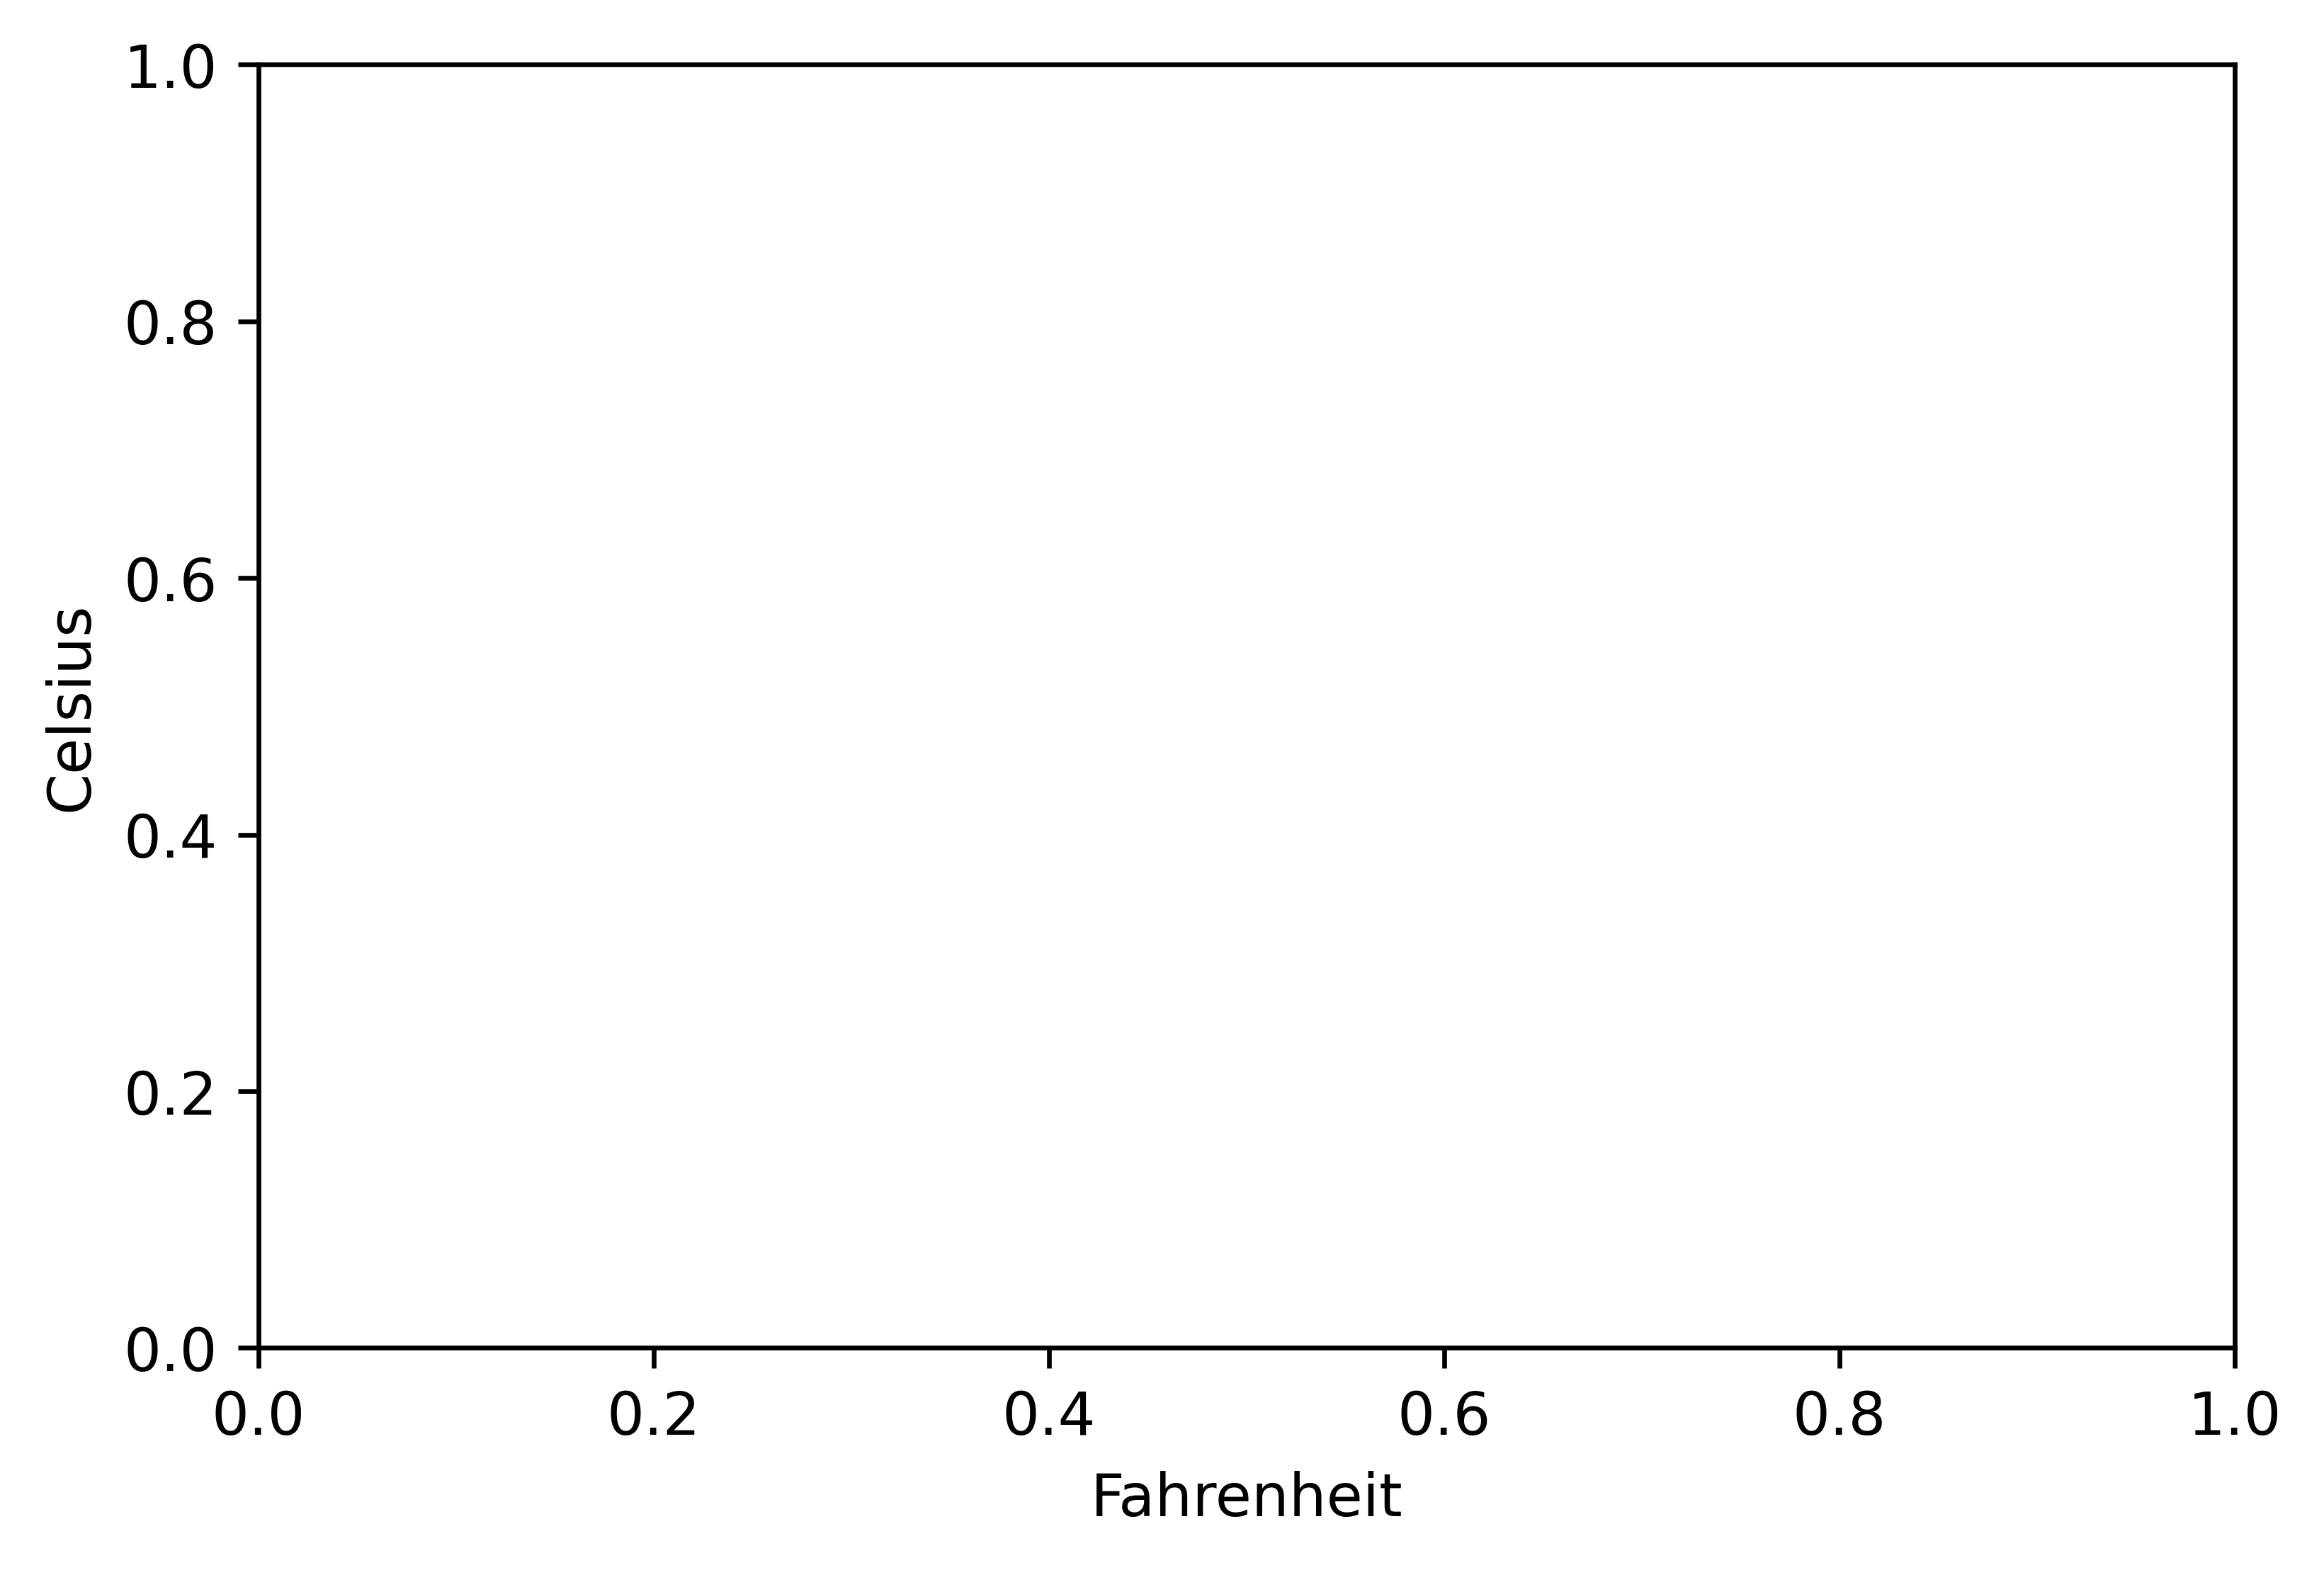

In [58]:
from matplotlib import pyplot as plt

x_sample = torch.arange(0, 5, 0.1).unsqueeze(1)
h = scaler.inverse_transform(x_sample)
print(h)
# Split x and y scaler?
# how to show output?

fig = plt.figure(dpi=600)
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
# plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(scaler.fit(t_range)).detach().numpy(), 'c-')
# plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')

In [ ]:
# Exercises here!

neuron_count = 20

seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(1, neuron_count)),
    ('hidden_activation', nn.Tanh()),
    ('output_linear', nn.Linear(neuron_count, 1))
]))

optimizer = optim.SGD(seq_model.parameters(), lr=1e-4)

training_loop(
    n_epochs = 5000, 
    optimizer = optimizer,
    model = seq_model,
    loss_fn = nn.MSELoss(),
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val)

from matplotlib import pyplot as plt

t_range = torch.arange(20., 90.).unsqueeze(1)

fig = plt.figure(dpi=150)
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')
